In [116]:
print("test")

test


In [117]:
# simple social-graph based simulation
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numba.cuda
import time
import numba
import random
from numba import jit
import numpy as np
from numpy import *
from numba import njit, prange
from numba import cuda, float32
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import statistics
import seaborn
#import cupy as cp
import pandas as pd
import networkx as nx

import math
from scipy.special import lambertw
import matplotlib.pyplot as plt

In [118]:
#subroutines for contagion, testing, contact counting and random graph generation

#test and isolate (delay or no delay)
@jit('int32[:](int8[:],int8[:],int8[:,:],float32[:],float32[:],int8[:],int8[:])', fastmath=True, nogil=True, cache=True, parallel=True)
def test_and_isolate_jit(virus_input, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay):
        
        change = np.int32([0,0])
        
        testing_strategy     = test_parameters[0]
        test_interval        = test_parameters[1]
        test_true_positive   = test_parameters[2]
        isolation_compliance = test_parameters[3]
        isolate_contacts     = test_parameters[4]
        test_time            = test_parameters[5]
        contact_bias         = test_parameters[6]
        test_delay_time      = test_parameters[7]
        trace_delay_time     = test_parameters[8]
        
        current_contact_bias = 1
        
        if (testing_strategy == 1):
            test_probability = 1 / test_interval
        else:
            test_probability = 1
        
        # random test 
        for j in prange(len(virus_input)):
            # test
            if (testing_strategy >= 1):
                if (contact_bias > 0): 
                    current_contact_bias = contact_bias * fraction_of_contacts[j]
                if ((test_time == 0 or virus_input[j] == int32(test_time)) and virus_input[j] != 0 and np.random.uniform(0, 1) < test_probability * current_contact_bias):
                    if (np.random.uniform(0, 1) < test_true_positive * isolation_compliance):
                        test_delay[j] = 1
                            
        # increments test delay vector and finds positives, sets trace delay           
        for j in prange(len(virus_input)):
            if (test_delay[j] != 0): 
                test_delay[j] += 1
            if (test_delay[j] >= 2 + test_delay_time):
                virus_input[j] = 0
                test_delay[j]  = 0
                trace_delay[j] = 1
        
        # increments trace delay vector and isolates contacts
        if (isolate_contacts > 0):
            for j in prange(len(virus_input)):
                if (trace_delay[j] != 0): 
                    trace_delay[j] += 1
                if (trace_delay[j] >= 2 + trace_delay_time):
                    for k in prange(len(social_graph)):
                        if (k != j and social_graph[k][j] > 0 and np.random.uniform(0, 1) < isolation_compliance * isolate_contacts):
                            virus_input[k] = 0
                            test_delay[k]  = 0
                            trace_delay[j] = 0

        # counts immune and infected
        for j in range(len(social_graph[0])):
            change[0] += (virus_input[j] != 0)
            change[1] += (immunity[j] == 0)
                             
        return(change)
    
    
#stepwise discrete contagion
@njit('int32[:](int8[:],int8[:],int8[:,:],int8[:],float32,int8)', fastmath=True, nogil=True, cache=True, parallel=True)
def discrete_contagion_jit(virus_input, immunity, social_graph, virus_tmp, transmission_probability, fixed_value):
        change = np.int32([0,0])
        graphsize = len(social_graph)
        for j in prange(graphsize):
            if (virus_input[j] != 0):
                
                for k in range(graphsize):
                    if (social_graph[k][j] * immunity[k] > 0):
                        if (k != j and np.random.uniform(0, 1) < transmission_probability):
                            virus_tmp[k] = fixed_value
                            immunity[k]  = 0

                virus_tmp[j] = virus_input[j] - 1
                                
        for j in range(graphsize):
            virus_input[j] = virus_tmp[j]
            change[0] += (virus_tmp[j] != 0)
            change[1] += (immunity[j] == 0)
                             
        return(change)

#counts all non-self (diagonal) contacts from graph
@njit('int32(int8[:,:])', fastmath=True, parallel=False)
def count_contacts_jit_parallel(social_graph):
    contacts = np.int32(0)
    for i in range(len(social_graph[0])):
        for j in range(len(social_graph)):
            if (i == j): continue
            contacts += social_graph[i][j]
    return (contacts) 

#count number of incoming contacts
@njit('void(int8[:,:], int32[:])', fastmath=True, parallel=True)
def count_number_of_incoming_contacts_jit_parallel(social_graph, number_of_contacts):
    for j in prange(len(social_graph[0])):
        for k in prange(len(social_graph)):
            if (social_graph[j][k] == 0): continue
            if (j == k): continue
            number_of_contacts[k] += 1         
            
#generates random graph to (matrix) with diagonal of one (directly modifies data).
#cell values will be modified to exact value at probability_of_modifying_value 
#if exact value is -1, random value between 0 and max_value is used instead
@njit('void(int8[:,:], float32, int8, int8)', parallel=False)
def random_graph_diagonal_one_jit_parallel(graph_matrix, probability_of_modifying_value, exact_value, max_value):
    for j in range(len(graph_matrix[0])):
        for k in range(len(graph_matrix)):
            # adds value to a random cell
            if (random.uniform(0, 1) < probability_of_modifying_value):
                if (exact_value == 0): 
                    graph_matrix[j][k] = random.uniform(0, max_value)
                else: 
                    graph_matrix[j][k] = exact_value
                # makes matrix symmetric
                graph_matrix[k][j] = graph_matrix[j][k]
            # makes diagonal = 1
            if (j == k):
                graph_matrix[j][k] = 1    
                

In [119]:
# SUBROUTINE TO RUN ONE SIMULATION WITH TEST
@jit(parallel = False)
def simulation_with_test(virus, immunity, social_graph, odd_vector, fraction_of_contacts, test_parameters, test_delay, trace_delay, daily_transmission_probability):
    
    for days in range (1,4096):
        
        odd_vector = np.zeros(matrix_size, dtype=np.int8)
        change     = discrete_contagion_jit(virus,immunity,social_graph,odd_vector,daily_transmission_probability,infectious_period)
        #print (daily_transmission_probability, sum(virus))
        if (test_parameters[0] == 1):
            change = test_and_isolate_jit(virus, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay)
        if (test_parameters[0] == 2 and days % test_parameters[1] == 0):
            change = test_and_isolate_jit(virus, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay)
        else:
            # inactivates test but runs the subroutine to move delays
            save_value         = test_parameters[2]
            test_parameters[2] = 0
            change     = test_and_isolate_jit(virus, immunity, social_graph, fraction_of_contacts, test_parameters, test_delay, trace_delay)
            test_parameters[2] = save_value
        immune     = change[1]
        infected   = change[0]
        #print(days, infected)
        if (infected == 0): 
            break
    
    return (days,immune) 

# subroutine that initializes a model and runs a simulation
def initialize_and_run(name, test_parameters, output_data, daily_transmission_probability):
    
    test_delay                              = np.zeros(matrix_size, dtype=np.int8)
    trace_delay                             = np.zeros(matrix_size, dtype=np.int8)
    virus                                   = np.zeros(matrix_size, dtype=np.int8)
    immunity                                = np.ones (matrix_size, dtype=np.int8)
    odd_vector                              = np.zeros(matrix_size, dtype=np.int8)
    
    virus[simulations*start_from_fraction]    = infectious_period
    immunity[simulations*start_from_fraction] = 0
    
    result = simulation_with_test(virus, immunity, social_graph, odd_vector, fraction_of_contacts, test_parameters, test_delay, trace_delay, daily_transmission_probability)
    
    if (simulations % 200 == 0): print(R0, name, simulations, time.time()-start, result)
    output_data.at[total_simulations+simulations, (name+'_days')] = result[0]
    output_data.at[total_simulations+simulations, name] = result[1]

In [120]:
# sets up social graph
infectious_period          = 42
matrix_size                = 4000
average_number_of_contacts = 20
contacts                   = np.int32(0)

# fully connected
graph_type          = "Fully connected"
social_graph        = np.ones(shape=(matrix_size,matrix_size), dtype=np.int8)

# sets up social graph (Random)
graph_type        = "Random graph"
social_graph      = np.zeros(shape=(matrix_size,matrix_size), dtype=np.int8)
random_graph_diagonal_one_jit_parallel(social_graph, average_number_of_contacts / (matrix_size * 2), 1, 0)

# Barabasi_Albert
# graph_type        = "Barabasi Albert"
# social_network    = nx.barabasi_albert_graph(n=matrix_size, m=average_number_of_contacts//2)
# social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int8)
# for x in range(matrix_size):
#     social_graph[x][x] = 1

# determines contacts per individual for current graph
contacts                = count_contacts_jit_parallel(social_graph)
contacts_per_individual = contacts / matrix_size


start_from_fraction    = 1
number_of_simulations  = matrix_size // start_from_fraction

start        = time.time()
output_data  = pd.DataFrame()

test_parameters      = np.zeros(10, dtype=np.float32)

test_parameters[0] = 1                         #testing_strategy (1 = random, 2 = all at the same time)
test_parameters[1] = float32(infectious_period)        #test_interval
test_parameters[2] = 0.70                      #test_true_positive 
test_parameters[3] = 0.75                      #isolation_compliance
test_parameters[4] = 0                         #isolate_contacts (tracing efficiency)
test_parameters[5] = 0                          #test time relative to infectious period (0 is all the time)
#test_parameters[5] = infectious_period//2      #test_time
test_parameters[6] = 0                         #fractional_bias_based_on_contact_freq
test_parameters[7] = 0                         #test delay time
test_parameters[8] = 0                         #trace delay time
parameter_memory = np.copy(test_parameters)

# counts number of contacts for each individual, and determines fraction of contacts
number_of_contacts              = np.zeros(matrix_size, dtype=np.int32)
count_number_of_incoming_contacts_jit_parallel(social_graph, number_of_contacts)
fraction_of_contacts = np.array(np.divide(number_of_contacts, statistics.mean(number_of_contacts)), dtype=np.float32)


In [ ]:
# Simulation across a parameter range (test interval using a random test)

# sets up R0
#R0           = 2.8569
#R0           = 2.35
start               = time.time()
#R0range             = np.linspace(1.2,3.5,num=10)
R0range             = [1.2100,1.4899,1.7616,2.0255,2.2818,2.5310,2.7732,3.0088,3.2380,3.4612]
#R0range             = [1.6850,2.0628,2.4253,2.7735,3.1081,3.4300,3.7398,4.0383,4.3260,4.6035]
R0range             = [1.4901, 1.7618, 2.0257, 2.2821, 2.5312,2.7735, 3.0091, 3.2384, 3.4615, 3.6788]
R0range             = [1.2100,1.4901, 1.7618, 2.0257, 2.2821, 2.5312,2.7735, 3.0091, 3.2384, 3.4615, 3.6788]

test_interval_range = list([1000000,496])+ list(range(496,248,-24)) + list(range(248,124,-12)) + list(range(168,84,-6)) + list(range(84,42,-3)) + list(range(42,5,-1))
test_interval_range   = list([1000000,1000])+ list(range(496,248,-96)) + list(range(248,124,-48)) + list(range(168,84,-24)) + list(range(84,51,-6))  + list(range(51,42,-3)) + list(range(42,5,-1))


simulations         = 0
total_simulations   = 0

for R0 in R0range:  
    for test_parameters[1] in test_interval_range:
    # sets daily transmission probability based on contacts per individual and R0
        daily_transmission_probability = R0 / (contacts_per_individual * infectious_period)
        print(contacts, contacts_per_individual, daily_transmission_probability, daily_transmission_probability * contacts_per_individual * infectious_period)
        for simulations in range (number_of_simulations):
            if (test_parameters[1] == 42):
                output_data.at[simulations+total_simulations, "R0"] = R0
            initialize_and_run("interval_"+str(test_parameters[1]), test_parameters, output_data, daily_transmission_probability)
            #print(simulations, time.time()-start, flush=True)
    total_simulations += simulations        

print(time.time()-start, flush=True)

78892 19.723 0.0014607069821793747 1.2099999999999997
1.21 interval_1000000.0 0 0.5645303726196289 (84, 2)
1.21 interval_1000000.0 200 29.95564079284668 (1534, 1094)
1.21 interval_1000000.0 400 59.49659252166748 (42, 1)
1.21 interval_1000000.0 600 89.76152348518372 (231, 14)
1.21 interval_1000000.0 800 116.94495439529419 (42, 1)
1.21 interval_1000000.0 1000 151.92130398750305 (1066, 972)
1.21 interval_1000000.0 1200 183.62078022956848 (1044, 1325)
1.21 interval_1000000.0 1400 216.17835521697998 (173, 14)
1.21 interval_1000000.0 1600 253.23562908172607 (81, 3)
1.21 interval_1000000.0 1800 285.24889874458313 (57, 2)
1.21 interval_1000000.0 2000 320.0281937122345 (1271, 1096)
1.21 interval_1000000.0 2200 353.8776044845581 (42, 1)
1.21 interval_1000000.0 2400 387.133517742157 (42, 1)
1.21 interval_1000000.0 2600 425.89790177345276 (1022, 1365)
1.21 interval_1000000.0 2800 464.2012493610382 (42, 1)
1.21 interval_1000000.0 3000 498.52819991111755 (1310, 935)
1.21 interval_1000000.0 3200 527.

1.21 interval_152.0 1200 3578.896645307541 (247, 29)
1.21 interval_152.0 1400 3593.9984607696533 (42, 1)
1.21 interval_152.0 1600 3608.4423518180847 (596, 96)
1.21 interval_152.0 1800 3622.7952671051025 (22, 1)
1.21 interval_152.0 2000 3635.0890204906464 (58, 3)
1.21 interval_152.0 2200 3645.4276471138 (42, 1)
1.21 interval_152.0 2400 3659.1831002235413 (92, 3)
1.21 interval_152.0 2600 3677.132545232773 (986, 428)
1.21 interval_152.0 2800 3690.112062215805 (146, 33)
1.21 interval_152.0 3000 3703.7795419692993 (894, 862)
1.21 interval_152.0 3200 3717.152142763138 (42, 1)
1.21 interval_152.0 3400 3731.047230243683 (42, 1)
1.21 interval_152.0 3600 3744.345307826996 (98, 4)
1.21 interval_152.0 3800 3759.282457113266 (911, 850)
78892 19.723 0.0014607069821793747 1.2099999999999997
1.21 interval_168.0 0 3773.3934111595154 (1147, 766)
1.21 interval_168.0 200 3791.3335967063904 (140, 17)
1.21 interval_168.0 400 3806.5689780712128 (909, 810)
1.21 interval_168.0 600 3821.725929737091 (42, 1)
1.2

1.21 interval_72.0 3800 5269.798069477081 (816, 289)
78892 19.723 0.0014607069821793747 1.2099999999999997
1.21 interval_66.0 0 5277.533005475998 (1, 1)
1.21 interval_66.0 200 5282.498891592026 (42, 2)
1.21 interval_66.0 400 5287.71147441864 (97, 7)
1.21 interval_66.0 600 5292.985552787781 (42, 1)
1.21 interval_66.0 800 5299.396285057068 (9, 1)
1.21 interval_66.0 1000 5305.260100841522 (92, 6)
1.21 interval_66.0 1200 5311.476228713989 (42, 2)
1.21 interval_66.0 1400 5317.663791418076 (112, 8)
1.21 interval_66.0 1600 5324.095451116562 (20, 1)
1.21 interval_66.0 1800 5330.065178871155 (418, 47)
1.21 interval_66.0 2000 5336.120833158493 (164, 21)
1.21 interval_66.0 2200 5343.566965818405 (13, 1)
1.21 interval_66.0 2400 5349.613386392593 (20, 1)
1.21 interval_66.0 2600 5355.780702590942 (42, 1)
1.21 interval_66.0 2800 5362.099344491959 (117, 7)
1.21 interval_66.0 3000 5367.677843093872 (50, 3)
1.21 interval_66.0 3200 5373.513938188553 (42, 1)
1.21 interval_66.0 3400 5378.427669763565 (841,

1.21 interval_41.0 2800 5996.586045265198 (82, 5)
1.21 interval_41.0 3000 5999.990297794342 (75, 8)
1.21 interval_41.0 3200 6003.819138050079 (46, 2)
1.21 interval_41.0 3400 6007.040658950806 (93, 4)
1.21 interval_41.0 3600 6010.62708067894 (4, 1)
1.21 interval_41.0 3800 6014.337841510773 (30, 1)
78892 19.723 0.0014607069821793747 1.2099999999999997
1.21 interval_40.0 0 6017.678461313248 (160, 14)
1.21 interval_40.0 200 6020.937160253525 (33, 2)
1.21 interval_40.0 400 6024.3496198654175 (100, 3)
1.21 interval_40.0 600 6027.799107313156 (174, 16)
1.21 interval_40.0 800 6031.493582487106 (50, 4)
1.21 interval_40.0 1000 6035.5807428359985 (42, 1)
1.21 interval_40.0 1200 6038.752130508423 (29, 1)
1.21 interval_40.0 1400 6041.934562921524 (77, 6)
1.21 interval_40.0 1600 6045.513834238052 (42, 2)
1.21 interval_40.0 1800 6048.295230388641 (91, 12)
1.21 interval_40.0 2000 6051.672479391098 (42, 1)
1.21 interval_40.0 2200 6055.755390405655 (42, 1)
1.21 interval_40.0 2400 6059.652493715286 (42, 

1.21 interval_33.0 2000 6502.608709573746 (19, 1)
1.21 interval_33.0 2200 6505.910818576813 (42, 1)
1.21 interval_33.0 2400 6508.984830617905 (51, 2)
1.21 interval_33.0 2600 6511.586870908737 (42, 1)
1.21 interval_33.0 2800 6514.713303804398 (13, 1)
1.21 interval_33.0 3000 6517.5823793411255 (11, 1)
1.21 interval_33.0 3200 6520.860089540482 (156, 12)
1.21 interval_33.0 3400 6523.791669845581 (42, 1)
1.21 interval_33.0 3600 6527.06628036499 (42, 1)
1.21 interval_33.0 3800 6529.615352153778 (42, 1)
78892 19.723 0.0014607069821793747 1.2099999999999997
1.21 interval_32.0 0 6532.272602558136 (72, 6)
1.21 interval_32.0 200 6534.803505182266 (228, 35)
1.21 interval_32.0 400 6537.827237844467 (117, 6)
1.21 interval_32.0 600 6540.294721364975 (9, 1)
1.21 interval_32.0 800 6542.763573408127 (7, 1)
1.21 interval_32.0 1000 6545.3969757556915 (173, 15)
1.21 interval_32.0 1200 6548.2346868515015 (149, 13)
1.21 interval_32.0 1400 6551.3409152030945 (383, 40)
1.21 interval_32.0 1600 6554.306255578995

1.21 interval_25.0 1200 6905.148244380951 (55, 2)
1.21 interval_25.0 1400 6907.46359038353 (28, 3)
1.21 interval_25.0 1600 6909.644166469574 (1, 1)
1.21 interval_25.0 1800 6911.704998731613 (25, 1)
1.21 interval_25.0 2000 6914.170444726944 (95, 7)
1.21 interval_25.0 2200 6916.560973644257 (83, 3)
1.21 interval_25.0 2400 6918.691426992416 (42, 2)
1.21 interval_25.0 2600 6921.0721690654755 (42, 1)
1.21 interval_25.0 2800 6923.367609500885 (16, 3)
1.21 interval_25.0 3000 6925.6242933273315 (19, 1)
1.21 interval_25.0 3200 6927.974804401398 (42, 1)
1.21 interval_25.0 3400 6930.279979705811 (7, 1)
1.21 interval_25.0 3600 6932.62496304512 (21, 1)
1.21 interval_25.0 3800 6934.88374209404 (39, 1)
78892 19.723 0.0014607069821793747 1.2099999999999997
1.21 interval_24.0 0 6937.055852651596 (42, 1)
1.21 interval_24.0 200 6939.255244731903 (116, 10)
1.21 interval_24.0 400 6941.485786437988 (1, 1)
1.21 interval_24.0 600 6943.515905380249 (104, 13)
1.21 interval_24.0 800 6945.669703006744 (42, 1)
1.2

1.21 interval_17.0 600 7210.785170555115 (29, 1)
1.21 interval_17.0 800 7212.452641963959 (41, 1)
1.21 interval_17.0 1000 7214.019772768021 (1, 1)
1.21 interval_17.0 1200 7215.6822600364685 (42, 1)
1.21 interval_17.0 1400 7217.215440034866 (17, 2)
1.21 interval_17.0 1600 7218.819264888763 (42, 1)
1.21 interval_17.0 1800 7220.3580157756805 (10, 1)
1.21 interval_17.0 2000 7222.132986545563 (79, 6)
1.21 interval_17.0 2200 7223.752848625183 (2, 1)
1.21 interval_17.0 2400 7225.451587438583 (94, 8)
1.21 interval_17.0 2600 7226.993337154388 (37, 1)
1.21 interval_17.0 2800 7228.431401968002 (42, 1)
1.21 interval_17.0 3000 7229.991055250168 (53, 2)
1.21 interval_17.0 3200 7231.904144048691 (38, 2)
1.21 interval_17.0 3400 7233.494451522827 (42, 1)
1.21 interval_17.0 3600 7235.269756317139 (36, 1)
1.21 interval_17.0 3800 7236.918210029602 (45, 5)
78892 19.723 0.0014607069821793747 1.2099999999999997
1.21 interval_16.0 0 7238.637558460236 (21, 1)
1.21 interval_16.0 200 7239.923694610596 (4, 1)
1.2

1.21 interval_9.0 200 7410.185289144516 (6, 2)
1.21 interval_9.0 400 7410.971091032028 (1, 1)
1.21 interval_9.0 600 7411.815569639206 (42, 3)
1.21 interval_9.0 800 7412.743604183197 (9, 1)
1.21 interval_9.0 1000 7413.577456712723 (31, 2)
1.21 interval_9.0 1200 7414.343396425247 (13, 1)
1.21 interval_9.0 1400 7415.208189249039 (19, 1)
1.21 interval_9.0 1600 7416.002566576004 (33, 2)
1.21 interval_9.0 1800 7416.72639131546 (5, 1)
1.21 interval_9.0 2000 7417.646894454956 (42, 1)
1.21 interval_9.0 2200 7418.548314332962 (1, 1)
1.21 interval_9.0 2400 7419.412226200104 (25, 4)
1.21 interval_9.0 2600 7420.1318390369415 (47, 2)
1.21 interval_9.0 2800 7420.972837686539 (68, 2)
1.21 interval_9.0 3000 7421.902775287628 (3, 1)
1.21 interval_9.0 3200 7422.737943410873 (3, 1)
1.21 interval_9.0 3400 7423.609483718872 (17, 1)
1.21 interval_9.0 3600 7424.545773983002 (3, 1)
1.21 interval_9.0 3800 7425.448608160019 (6, 1)
78892 19.723 0.0014607069821793747 1.2099999999999997
1.21 interval_8.0 0 7426.324

1.4901 interval_400.0 2400 12620.29339313507 (96, 6)
1.4901 interval_400.0 2600 12689.149678230286 (65, 2)
1.4901 interval_400.0 2800 12759.429478645325 (859, 2010)
1.4901 interval_400.0 3000 12820.992054224014 (650, 1998)
1.4901 interval_400.0 3400 12957.981852293015 (66, 2)
1.4901 interval_400.0 3600 13029.305834054947 (42, 1)
1.4901 interval_400.0 3800 13093.535765647888 (42, 1)
78892 19.723 0.0017988425406161045 1.4901
1.4901 interval_304.0 0 13157.586314201355 (73, 3)
1.4901 interval_304.0 200 13213.35991692543 (82, 3)
1.4901 interval_304.0 400 13276.464270830154 (165, 13)
1.4901 interval_304.0 600 13340.639206886292 (704, 1935)
1.4901 interval_304.0 800 13399.30774474144 (710, 2084)
1.4901 interval_304.0 1000 13459.713671684265 (204, 9)
1.4901 interval_304.0 1200 13525.57617688179 (793, 2145)
1.4901 interval_304.0 1400 13590.48006272316 (651, 1855)
1.4901 interval_304.0 1600 13655.973761796951 (42, 1)
1.4901 interval_304.0 1800 13728.321563005447 (628, 2138)
1.4901 interval_304.0

1.4901 interval_120.0 3200 21217.857933044434 (16, 1)
1.4901 interval_120.0 3400 21268.052844762802 (81, 7)
1.4901 interval_120.0 3600 21327.66866016388 (42, 1)
1.4901 interval_120.0 3800 21384.35173177719 (42, 1)
78892 19.723 0.0017988425406161045 1.4901
1.4901 interval_96.0 0 21430.508586883545 (42, 2)
1.4901 interval_96.0 200 21472.503507375717 (124, 12)
1.4901 interval_96.0 400 21513.412642240524 (85, 3)
1.4901 interval_96.0 600 21561.777890205383 (711, 1503)
1.4901 interval_96.0 800 21598.500247240067 (42, 1)
1.4901 interval_96.0 1000 21643.17564868927 (42, 2)
1.4901 interval_96.0 1200 21691.617642879486 (793, 1435)
1.4901 interval_96.0 1400 21734.082520008087 (828, 1628)
1.4901 interval_96.0 1600 21783.752561569214 (42, 1)
1.4901 interval_96.0 1800 21834.860858678818 (893, 1609)
1.4901 interval_96.0 2000 21879.767231464386 (72, 5)
1.4901 interval_96.0 2200 21924.39486002922 (27, 1)
1.4901 interval_96.0 2400 21972.611559152603 (871, 1610)
1.4901 interval_96.0 2600 22023.2647387981

1.4901 interval_51.0 600 26542.7385327816 (942, 885)
1.4901 interval_51.0 800 26563.808312416077 (42, 1)
1.4901 interval_51.0 1000 26584.198304653168 (42, 1)
1.4901 interval_51.0 1200 26608.41219186783 (95, 6)
1.4901 interval_51.0 1400 26632.7294819355 (1, 1)
1.4901 interval_51.0 1600 26656.253028154373 (119, 9)
1.4901 interval_51.0 1800 26677.444118499756 (63, 4)
1.4901 interval_51.0 2000 26700.58743619919 (3, 1)
1.4901 interval_51.0 2200 26721.8564081192 (24, 1)
1.4901 interval_51.0 2400 26739.422795534134 (80, 3)
1.4901 interval_51.0 2600 26763.055853128433 (6, 1)
1.4901 interval_51.0 2800 26779.34945988655 (121, 5)
1.4901 interval_51.0 3000 26803.244283914566 (1577, 993)
1.4901 interval_51.0 3200 26829.3276386261 (315, 67)
1.4901 interval_51.0 3400 26851.134617090225 (28, 1)
1.4901 interval_51.0 3600 26874.78664278984 (113, 9)
1.4901 interval_51.0 3800 26896.47440958023 (847, 1123)
78892 19.723 0.0017988425406161045 1.4901
1.4901 interval_48.0 0 26921.8071038723 (42, 1)
1.4901 inte

1.4901 interval_38.0 2600 28811.825784683228 (42, 1)
1.4901 interval_38.0 2800 28823.494346380234 (42, 1)
1.4901 interval_38.0 3000 28833.21915793419 (32, 2)
1.4901 interval_38.0 3200 28843.48947453499 (128, 10)
1.4901 interval_38.0 3400 28855.496280431747 (42, 1)
1.4901 interval_38.0 3600 28866.94429588318 (42, 2)
1.4901 interval_38.0 3800 28878.854254722595 (93, 7)
78892 19.723 0.0017988425406161045 1.4901
1.4901 interval_37.0 0 28888.94922232628 (68, 6)
1.4901 interval_37.0 200 28899.601145029068 (134, 5)
1.4901 interval_37.0 400 28910.465075969696 (23, 1)
1.4901 interval_37.0 600 28920.599012374878 (62, 6)
1.4901 interval_37.0 800 28931.17815542221 (42, 2)
1.4901 interval_37.0 1000 28942.282366275787 (139, 10)
1.4901 interval_37.0 1200 28950.212651729584 (149, 8)
1.4901 interval_37.0 1400 28960.98716044426 (16, 1)
1.4901 interval_37.0 1600 28968.94354391098 (60, 2)
1.4901 interval_37.0 1800 28979.580332279205 (3, 1)
1.4901 interval_37.0 2000 28987.269226312637 (30, 2)
1.4901 interv

1.4901 interval_30.0 600 30032.20257616043 (13, 1)
1.4901 interval_30.0 800 30038.853801250458 (44, 2)
1.4901 interval_30.0 1000 30044.43791437149 (7, 1)
1.4901 interval_30.0 1200 30050.206055402756 (97, 4)
1.4901 interval_30.0 1400 30055.752522468567 (54, 4)
1.4901 interval_30.0 1600 30060.75296854973 (35, 1)
1.4901 interval_30.0 1800 30066.949333906174 (160, 10)
1.4901 interval_30.0 2000 30072.5390689373 (6, 1)
1.4901 interval_30.0 2200 30077.486323833466 (86, 9)
1.4901 interval_30.0 2400 30082.244619607925 (45, 2)
1.4901 interval_30.0 2600 30088.217161417007 (42, 1)
1.4901 interval_30.0 2800 30092.616696834564 (157, 16)
1.4901 interval_30.0 3000 30097.967657327652 (83, 4)
1.4901 interval_30.0 3200 30103.238384962082 (117, 16)
1.4901 interval_30.0 3400 30109.20391726494 (474, 185)
1.4901 interval_30.0 3600 30115.38089299202 (380, 69)
1.4901 interval_30.0 3800 30121.89589715004 (1, 1)
78892 19.723 0.0017988425406161045 1.4901
1.4901 interval_29.0 0 30127.11837911606 (61, 2)
1.4901 int

1.4901 interval_23.0 2800 30669.811492919922 (95, 11)
1.4901 interval_23.0 3000 30672.892678022385 (343, 131)
1.4901 interval_23.0 3200 30676.358727931976 (3, 1)
1.4901 interval_23.0 3400 30679.15008020401 (41, 2)
1.4901 interval_23.0 3600 30682.19672870636 (1, 1)
1.4901 interval_23.0 3800 30685.561737298965 (67, 3)
78892 19.723 0.0017988425406161045 1.4901
1.4901 interval_22.0 0 30688.851988077164 (29, 5)
1.4901 interval_22.0 200 30691.794409036636 (69, 3)
1.4901 interval_22.0 400 30694.185591220856 (42, 2)
1.4901 interval_22.0 600 30696.98457121849 (5, 1)
1.4901 interval_22.0 800 30700.084901809692 (21, 1)
1.4901 interval_22.0 1000 30703.2423453331 (149, 9)
1.4901 interval_22.0 1200 30706.245331048965 (224, 40)
1.4901 interval_22.0 1400 30708.684674263 (75, 13)
1.4901 interval_22.0 1600 30711.40507054329 (29, 1)
1.4901 interval_22.0 1800 30714.427502155304 (66, 10)
1.4901 interval_22.0 2000 30717.58899140358 (42, 1)
1.4901 interval_22.0 2200 30720.571938753128 (25, 1)
1.4901 interval

1.4901 interval_15.0 1000 31024.963624477386 (66, 2)
1.4901 interval_15.0 1200 31026.621513843536 (42, 1)
1.4901 interval_15.0 1400 31028.310219287872 (33, 1)
1.4901 interval_15.0 1600 31030.17963051796 (20, 3)
1.4901 interval_15.0 1800 31032.111293792725 (36, 1)
1.4901 interval_15.0 2000 31033.909930706024 (45, 3)
1.4901 interval_15.0 2200 31035.685720443726 (4, 1)
1.4901 interval_15.0 2400 31037.37092089653 (3, 1)
1.4901 interval_15.0 2600 31039.040511131287 (13, 1)
1.4901 interval_15.0 2800 31040.551435232162 (20, 1)
1.4901 interval_15.0 3000 31042.062660455704 (4, 2)
1.4901 interval_15.0 3200 31043.97204518318 (68, 7)
1.4901 interval_15.0 3400 31045.760175943375 (9, 1)
1.4901 interval_15.0 3600 31047.480495929718 (7, 1)
1.4901 interval_15.0 3800 31049.16444826126 (2, 1)
78892 19.723 0.0017988425406161045 1.4901
1.4901 interval_14.0 0 31050.89322590828 (74, 7)
1.4901 interval_14.0 200 31052.616173028946 (17, 1)
1.4901 interval_14.0 400 31054.197731256485 (31, 1)
1.4901 interval_14.0

1.4901 interval_8.0 3600 31215.213534832 (7, 1)
1.4901 interval_8.0 3800 31216.058450698853 (25, 2)
78892 19.723 0.0017988425406161045 1.4901
1.4901 interval_7.0 0 31216.986778259277 (13, 1)
1.4901 interval_7.0 200 31217.723393440247 (8, 2)
1.4901 interval_7.0 400 31218.35890841484 (46, 7)
1.4901 interval_7.0 600 31219.08126926422 (15, 2)
1.4901 interval_7.0 800 31219.762586593628 (7, 2)
1.4901 interval_7.0 1000 31220.46498823166 (4, 1)
1.4901 interval_7.0 1200 31221.129225492477 (36, 3)
1.4901 interval_7.0 1400 31221.88794851303 (23, 1)
1.4901 interval_7.0 1600 31222.68165063858 (20, 1)
1.4901 interval_7.0 1800 31223.299406290054 (33, 3)
1.4901 interval_7.0 2000 31224.001120328903 (15, 1)
1.4901 interval_7.0 2200 31224.63774037361 (13, 1)
1.4901 interval_7.0 2400 31225.32213950157 (31, 4)
1.4901 interval_7.0 2600 31226.006866693497 (22, 3)
1.4901 interval_7.0 2800 31226.624126195908 (16, 3)
1.4901 interval_7.0 3000 31227.30916905403 (28, 3)
1.4901 interval_7.0 3200 31228.05049586296 (

1.7618 interval_248.0 400 40595.72312116623 (706, 2664)
1.7618 interval_248.0 600 40681.653499126434 (679, 2681)
1.7618 interval_248.0 800 40772.42856287956 (530, 2638)
1.7618 interval_248.0 1000 40856.50908255577 (650, 2505)
1.7618 interval_248.0 1200 40942.156180143356 (42, 1)
1.7618 interval_248.0 1400 41027.783746004105 (567, 2632)
1.7618 interval_248.0 1600 41116.92379331589 (42, 1)
1.7618 interval_248.0 1800 41196.5184135437 (14, 1)
1.7618 interval_248.0 2000 41278.47859978676 (862, 2615)
1.7618 interval_248.0 2200 41361.971915483475 (572, 2539)
1.7618 interval_248.0 2400 41448.087060689926 (133, 6)
1.7618 interval_248.0 2600 41532.67211937904 (219, 11)
1.7618 interval_248.0 2800 41622.595499038696 (584, 2606)
1.7618 interval_248.0 3000 41705.09420466423 (608, 2571)
1.7618 interval_248.0 3200 41785.46588921547 (44, 2)
1.7618 interval_248.0 3400 41877.41934609413 (652, 2595)
1.7618 interval_248.0 3600 41962.42988371849 (57, 2)
1.7618 interval_248.0 3800 42047.997289419174 (525, 25

1.7618 interval_84.0 1200 51902.58386301994 (5, 1)
1.7618 interval_84.0 1400 51973.84605383873 (2, 1)
1.7618 interval_84.0 1600 52033.04044222832 (72, 3)
1.7618 interval_84.0 1800 52096.25429725647 (42, 1)
1.7618 interval_84.0 2000 52169.197264671326 (43, 2)
1.7618 interval_84.0 2200 52241.200553417206 (42, 1)
1.7618 interval_84.0 2400 52304.1765897274 (648, 2412)
1.7618 interval_84.0 2600 52370.615149497986 (677, 2290)
1.7618 interval_84.0 2800 52440.600749492645 (695, 2221)
1.7618 interval_84.0 3000 52517.348224401474 (622, 2257)
1.7618 interval_84.0 3200 52587.724680662155 (137, 10)
1.7618 interval_84.0 3400 52656.283064603806 (89, 6)
1.7618 interval_84.0 3600 52725.038140296936 (121, 13)
1.7618 interval_84.0 3800 52789.976811647415 (599, 2329)
78892 19.723 0.0021268376538872914 1.7618
1.7618 interval_78.0 0 52861.172959804535 (652, 2290)
1.7618 interval_78.0 200 52918.21757721901 (42, 2)
1.7618 interval_78.0 400 52984.663987874985 (803, 2283)
1.7618 interval_78.0 600 53048.15570044

In [ ]:
#newsim = output_data.iloc[:, 112:]
newsim = output_data
print(len(newsim), len(newsim))
newsim

In [ ]:
#test_interval_range = list([1000000,168]) + list(range(84,42,-3)) + list(range(42,0,-1))

In [ ]:
# plots a figure
import seaborn
from itertools import compress

Fig2 = plt.figure(figsize=(20,6))

daily_fraction = []
max_size       = []
average_size   = []
less_than_100  = []
R0s            = []
max_size_over_fraction_of_large = []

#test_interval_range = range (42,0,-1)
for R0 in R0range:
    c = newsim['R0'] == R0
    for i in test_interval_range:
        current_column = "interval_"+str(i)+".0"
        #ax = seaborn.scatterplot(newsim[current_column + "_days"], newsim[current_column], alpha = 0.3, label = str(math.trunc(100/i)/100))
        current_sizes = newsim[current_column][c]
        average_size.append(statistics.mean(current_sizes)/matrix_size)  
        max_fraction_infected       = max(current_sizes)/matrix_size
        fraction_of_small_epidemics = sum(current_sizes < 100) / number_of_simulations

        max_size.append(max_fraction_infected)
        less_than_100.append(fraction_of_small_epidemics)
        #if (fraction_of_large_epidemics > 0):
        #    max_size_over_fraction_of_large.append(max_fraction_infected / fraction_of_large_epidemics)
        #else:
        #    max_size_over_fraction_of_large.append(0)

        daily_fraction.append(6/i)
        R0s.append(R0)

plt.xlabel("$\itdays$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 14)
#ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 4, loc = 4)

plt.subplot(131)
for R0 in R0range:
    print(R0)
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(max_size,c)), label = str(R0))
    #ax = seaborn.scatterplot(daily_fraction, average_size, label = "average size")
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 14)
ax.set_xlim(0,1)
ax.set_title("$\itmaximum\ size$", fontsize = 16)

plt.subplot(132)
for R0 in R0range:
    print(R0)
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(average_size,c)), label = str(R0))
    #ax = seaborn.scatterplot(daily_fraction, average_size, label = "average size")
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 14)
ax.set_xlim(0,1)
ax.set_title("$\itaverage\ size$", fontsize = 16)

plt.subplot(133)
for R0 in R0range:
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(less_than_100,c)), label = str(R0))
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 14)
plt.ylabel("$\itfraction\ of\ small\ epidemics$", fontsize = 14)
ax.set_xlim(0,1)
ax.set_title("$\itfraction\ of\ small$", fontsize = 16)

Fig2.savefig("all_4k_20_contacts_6h_random_graph_with_random_testing_R0_range_up_to_"+str(R0)+".pdf")
Fig2.savefig("all_4k_20_contacts_6h_random_graph_with_random_testing_R0_range_up_to_"+str(R0)+".png")

### len(test_interval_range)

In [ ]:
compression_opts = dict(method='zip',
                        archive_name='all_4k_random_sim_intervals_R0_up_to_'+str(R0)+'.csv')  
output_data.to_csv('all_4k_random_sim_intervals_R0_up_to_'+str(R0)+'.zip', index=False,
          compression=compression_opts)

In [ ]:
# plots a figure
newsim = output_data
import seaborn
from itertools import compress

Fig2 = plt.figure(figsize=(14,6))

daily_fraction       = []
max_size             = []
average_size         = []
average_large_size   = []
less_than_100        = []
R0s                  = []
max_size_over_fraction_of_large = []

#test_interval_range = range (42,0,-1)
for R0 in R0range:
    c = newsim['R0'] == R0
    for i in test_interval_range:
        current_column = "interval_"+str(i)+".0"
        #ax = seaborn.scatterplot(newsim[current_column + "_days"], newsim[current_column], alpha = 0.3, label = str(math.trunc(100/i)/100))
        current_sizes       = newsim[current_column][c]
        current_large_sizes = current_sizes[current_sizes >= 10]
        average_size.append(statistics.mean(current_sizes)/matrix_size)
        if (size(current_large_sizes) == 0): 
            average_large_size.append(0)
        else:
            average_large_size.append(statistics.mean(current_large_sizes)/matrix_size)
        max_fraction_infected       = max(current_sizes)/matrix_size
        fraction_of_small_epidemics = sum(current_sizes < 100) / number_of_simulations

        max_size.append(max_fraction_infected)
        less_than_100.append(fraction_of_small_epidemics)
        #if (fraction_of_large_epidemics > 0):
        #    max_size_over_fraction_of_large.append(max_fraction_infected / fraction_of_large_epidemics)
        #else:
        #    max_size_over_fraction_of_large.append(0)

        daily_fraction.append(6/i)
        R0s.append(R0)

plt.xlabel("$\itdays$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 14)
#ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 4, loc = 4)

plt.subplot(122)
for R0 in R0range:
    print(R0)
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(average_large_size,c)), label = str(R0))
    #ax = seaborn.scatterplot(daily_fraction, average_size, label = "average size")
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 14)
ax.set_xlim(0,1)
ax.set_title("$\itaverage\ size\ (>\ 10)$", fontsize = 16)

plt.subplot(121)
for R0 in R0range:
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(less_than_100,c)), label = str(R0))
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 14)
plt.ylabel("$\itfraction\ of\ small\ epidemics$", fontsize = 14)
ax.set_xlim(0,1)
ax.set_title("$\itfraction\ of\ small\ epidemics\ (<\ 100)$", fontsize = 16)

Fig2.savefig("all_final_7075_4k_20_contacts_6h_random_graph_with_random_testing_R0_range_up_to_"+str(R0)+".pdf")
Fig2.savefig("all_final_7075_4k_20_contacts_6h_random_graph_with_random_testing_R0_range_up_to_"+str(R0)+".png")

In [ ]:

newsim = output_data
colorlist = ['red','orange','purple','green','cyan','brown','blue','red','orange','purple']
R0range             = [1.2100,1.4901, 1.7618, 2.0257, 2.2821, 2.5312,2.7735, 3.0091, 3.2384, 3.4615, 3.6788]

Fig5 = plt.figure(figsize=(14,6))

daily_fraction       = []
max_size             = []
average_size         = []
average_large_size   = []
less_than_100        = []
R0s                  = []
max_size_over_fraction_of_large = []

#test_interval_range = range (42,0,-1)
for R0 in R0range:
    c = newsim['R0'] == R0
    for i in test_interval_range:
        current_column = "interval_"+str(i)+".0"
        #ax = seaborn.scatterplot(newsim[current_column + "_days"], newsim[current_column], alpha = 0.3, label = str(math.trunc(100/i)/100))
        current_sizes       = newsim[current_column][c]
        current_large_sizes = current_sizes[current_sizes > 10]
        average_size.append(statistics.mean(current_sizes)/matrix_size)
        if (len(current_large_sizes) == 0): 
            average_large_size.append(0)
        else:
            average_large_size.append(statistics.mean(current_large_sizes)/matrix_size)
        max_fraction_infected       = max(current_sizes)/matrix_size
        fraction_of_small_epidemics = sum(current_sizes < 100) / number_of_simulations

        max_size.append(max_fraction_infected)
        less_than_100.append(fraction_of_small_epidemics)
        #if (fraction_of_large_epidemics > 0):
        #    max_size_over_fraction_of_large.append(max_fraction_infected / fraction_of_large_epidemics)
        #else:
        #    max_size_over_fraction_of_large.append(0)

        daily_fraction.append(6/i)
        R0s.append(R0)

plt.xlabel("$\itdays$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 14)
#ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 4, loc = 4)

plt.subplot(122)
plt.xticks(horizontalalignment='center', fontsize = 18)
plt.yticks(verticalalignment='center', fontsize = 18)
i = 0
for R0 in R0range[:-1]:
    print(R0)
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(average_large_size,c)), label = str("{0:.2f}".format(R0)), color = colorlist[i])
    i += 1
    #ax = seaborn.scatterplot(daily_fraction, average_size, label = "average size")
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 18)
plt.ylabel("$\itinfected$", fontsize = 18)
ax.set_xlim(0,1.02)
ax.set_title("$\itaverage\ size\ (>\ 10)$", fontsize = 20)
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 16, loc = 1)


plt.subplot(121)
plt.xticks(horizontalalignment='center', fontsize = 18)
plt.yticks(verticalalignment='center', fontsize = 18)
i = 0
for R0 in R0range[1:]:
    c = np.array(R0s) == R0
    ax = seaborn.scatterplot(list(compress(daily_fraction,c)), list(compress(less_than_100,c)), label = str("{0:.2f}".format(R0)), color = colorlist[i])
    i += 1
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 18)
plt.ylabel("$\itfraction\ of\ small\ epidemics$", fontsize = 18)
ax.set_xlim(0,1.02)
ax.set_title("$\itfraction\ of\ small\ epidemics\ (<\ 100)$", fontsize = 20)
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 16, loc = 4)

plt.tight_layout(pad=1, h_pad=1, w_pad=2, rect=None)
Fig5.savefig("Fig5CD.pdf")
Fig5.savefig("Fig5CD.png", dpi=600)

1.21
1.4901
1.7618
2.0257
2.2821
2.5312
2.7735
3.0091
3.2384
3.4615


ValueError: arrays must all be same length

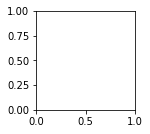

In [96]:

plt.subplot(233)
ax = seaborn.scatterplot(test_interval_range, max_size, label = "max size ("+str(number_of_simulations)+" sim.)")
ax = seaborn.scatterplot(test_interval_range, average_size, label = "average size")
ax = seaborn.scatterplot(test_interval_range, more_than_100, label = "fraction > 100 infected")
plt.xlabel("$\ittest\ interval$", fontsize = 14)
plt.ylabel("$\itinfected$", fontsize = 14)

plt.subplot(234)
ax = seaborn.scatterplot(daily_fraction, max_size, label = "max size (of "+str(number_of_simulations)+" simulations)")
ax = seaborn.scatterplot(daily_fraction, more_than_100, label = "epidemics > 100 infected", color = "green")
plt.xlabel("$\itfraction\ tested\ per\ day$", fontsize = 14)
plt.ylabel("$\itfraction$", fontsize = 14)

plt.subplot(235)
ax = seaborn.scatterplot(daily_fraction, max_size_over_fraction_of_large, label = "max size / epidemics>100 inf")
plt.xlabel("$\ittest\ interval$", fontsize = 14)
plt.ylabel("$\itratio$", fontsize = 14)
ax.legend(labelspacing=0.25, handletextpad = 0, fontsize = 10.5, loc = 4)

plt.tight_layout(pad=1, h_pad=1, w_pad=2, rect=None)


Fig2.savefig("10k_20_contacts_6h_BA_graph_with_random_testing_R0_"+str(R0)+".pdf")

In [ ]:
compression_opts = dict(method='zip',
                        archive_name='10k_2percentrandom_sim_ip_10_BA_intervals_R0_'+str(R0)+'.csv')  
output_data.to_csv('10k_2percentrandom_sim_ip_10_BA_intervals_R0_'+str(R0)+'.zip', index=False,
          compression=compression_opts)

In [ ]:
# other types of social graph (using NetworkX to generate, reformat as numpy matrix)

# sets up social graph (Random)
graph_type        = "Random graph"
social_graph      = np.zeros(shape=(matrix_size,matrix_size), dtype=np.int32)
random_graph_diagonal_one_jit_parallel(social_graph, average_number_of_contacts / (matrix_size * 2), 1, 0)

# 50-50 Mix of Barabasi_Albert and Random
graph_type        = "Barabasi Albert : Random 50:50"
social_network    = nx.barabasi_albert_graph(n=matrix_size, m=average_number_of_contacts//4)
social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int32)
random_graph_diagonal_one_jit_parallel(social_graph, average_number_of_contacts / (matrix_size * 4), 1, 0)
for x in range(matrix_size):
    social_graph[x][x] = 1
graphs[graph_type] = np.copy(social_graph)
    
# Small world
graph_type        = "Watts Strogatz small world"
social_network    = nx.watts_strogatz_graph(n=matrix_size, k=average_number_of_contacts, p=0.2, seed=None)
social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int32)
for x in range(matrix_size):
    social_graph[x][x] = 1
graphs[graph_type] = np.copy(social_graph)
    
# Barabasi_Albert
graph_type        = "Barabasi Albert"
social_network    = nx.barabasi_albert_graph(n=matrix_size, m=average_number_of_contacts//2)
social_graph      = np.array(nx.to_numpy_matrix(social_network), dtype = np.int32)
for x in range(matrix_size):
    social_graph[x][x] = 1
graphs[graph_type] = np.copy(social_graph)


In [ ]:
#@cuda.jit('void(int32[:],int32[:],int32[:,:],int32[:],float32,int32)')
def cuda_discrete_contagion(virus_input, immunity, social_graph, virus_tmp, transmission_probability, fixed_value, rng_states):
    row = cuda.grid(1)
    if (row < len(social_graph[0])):
        sum = 0

        for i in range(len(social_graph)):
            sum += (social_graph[row, i] * virus_input[i]) * immunity[i] * (np.random.uniform(0, 1) < xoroshiro128p_uniform_float32(rng_states, thread_id))

        virus_tmp[row] = (sum > 0) * 10
        
    if (row < len(social_graph[0])):
        for i in range(len(social_graph)):
            virus_input[i] = virus_tmp[i]

In [ ]:
dim(output_data)


In [ ]:
total_simulations  = 0
for R0 in R0range:
    for simulations in range (number_of_simulations):
        output_data.at[simulations+total_simulations, "R0"] = R0
    total_simulations += simulations 


In [112]:
R0range[1:], R0range[:-1]

([1.4901,
  1.7618,
  2.0257,
  2.2821,
  2.5312,
  2.7735,
  3.0091,
  3.2384,
  3.4615,
  3.6788],
 [1.21,
  1.4901,
  1.7618,
  2.0257,
  2.2821,
  2.5312,
  2.7735,
  3.0091,
  3.2384,
  3.4615])

In [128]:
output_data

,interval_1000000.0_days,interval_1000000.0,interval_1000.0_days,interval_1000.0,interval_496.0_days,interval_496.0,interval_400.0_days,interval_400.0,interval_304.0_days,interval_304.0,...,interval_10.0_days,interval_10.0,interval_9.0_days,interval_9.0,interval_8.0_days,interval_8.0,interval_7.0_days,interval_7.0,interval_6.0_days,interval_6.0
0,84.0,2.0,195.0,16.0,42.0,1.0,1155.0,1054.0,146.0,18.0,...,2.0,1.0,31.0,2.0,3.0,1.0,2.0,1.0,3.0,1.0
1,736.0,1091.0,77.0,5.0,194.0,23.0,42.0,1.0,52.0,2.0,...,3.0,1.0,32.0,1.0,15.0,2.0,23.0,2.0,5.0,1.0
2,42.0,1.0,1060.0,986.0,42.0,1.0,108.0,6.0,66.0,2.0,...,6.0,1.0,1.0,1.0,25.0,1.0,26.0,2.0,6.0,1.0
3,222.0,21.0,1388.0,1141.0,42.0,1.0,42.0,1.0,852.0,954.0,...,8.0,1.0,9.0,1.0,4.0,1.0,4.0,1.0,37.0,1.0
4,78.0,3.0,42.0,1.0,69.0,4.0,1089.0,912.0,42.0,1.0,...,1.0,1.0,13.0,1.0,5.0,1.0,15.0,2.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43985,235.0,3834.0,275.0,3818.0,269.0,3784.0,42.0,1.0,42.0,1.0,...,1.0,1.0,3.0,1.0,5.0,1.0,1.0,1.0,29.0,4.0
43986,254.0,3860.0,239.0,3854.0,260.0,3836.0,257.0,3802.0,275.0,3814.0,...,27.0,5.0,571.0,1476.0,659.0,670.0,278.0,127.0,7.0,1.0
43987,237.0,3850.0,237.0,3821.0,42.0,1.0,301.0,3828.0,284.0,3812.0,...,33.0,3.0,1.0,1.0,8.0,1.0,70.0,15.0,1.0,1.0
43988,235.0,3835.0,226.0,3854.0,296.0,3808.0,251.0,3825.0,273.0,3827.0,...,9.0,1.0,576.0,1620.0,165.0,57.0,9.0,1.0,5.0,1.0
